# Machine learning final project
- Your job is to develop tools to analyze tweets about airlines.
Download the following dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- You must develop at least two tools.
-a sentiment analysis tool to classify tweets as positive, negative, or neutral
a tool that clusters similar tweets for a particular airline together and selects a representative tweet from each cluster characterizing the cluster
Deliverables
- You will turn in a Jupyter notebook for each tool that demonstrates your work.
- Also, for each tool, you will turn in a report documenting the process you followed to make your choices about how to preprocess your data and how to build, tune, and test your tools as well as why you think those were reasonable choices to make
- The report must include an appropriate estimate of your sentiment classifier’s accuracy.
You are free to use resources you find online, just cite them AND explain what you learned from those resources.
You must convince me that you really understand what you did and why you did it.
- Don’t use it if you can’t explain it.
- For students in CSC 5220, you will also (individually) build a tool that identifies the 5 most frequent words (not counting stopwords) in positive tweets, negative tweets, and in each cluster you identify.

Gabriel Kiprono and William Lewis

## Step 1: Read the data

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import string

- Read the data

In [ ]:
tweets = pd.read_csv("Tweets.csv")
tweets.columns
tweets.head()

- Data visualization

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from termcolor import cprint
import seaborn as sns
import warnings   


warnings.filterwarnings('ignore')
%matplotlib inline

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


Text(0.5, 1.0, 'Null values of the dataset')

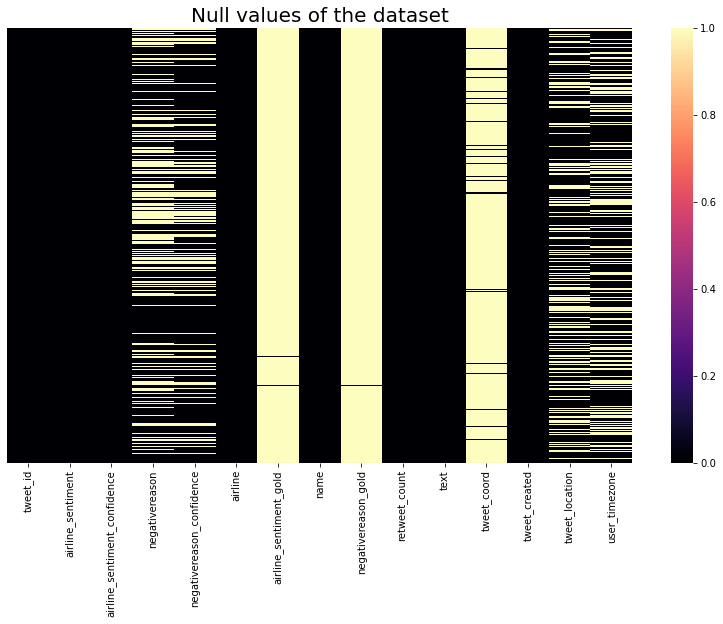

In [4]:
# nulls
print(tweets.isnull().sum())
plt.figure(figsize=(14,8))

#how is all null look like
sns.heatmap(tweets.isnull(), yticklabels=False, cmap='magma')
plt.title('Null values of the dataset', size=20)

In [ ]:
# plot a pie chart for airline_sentiment
fig = plt.figure(figsize = (10, 8))
labels = 'negative', 'neutral', 'positive'
plt.pie(tweets.airline_sentiment.value_counts(), labels = labels, autopct = '%1.1f%%', startangle = 90)
plt.title('Airline Sentiment', fontsize = 20)
plt.show()

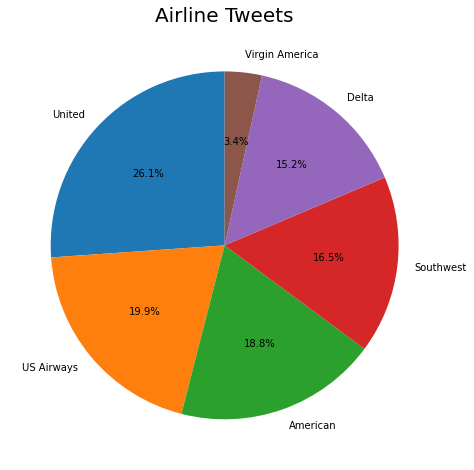

In [6]:
#pie chart for airlines tweets
fig = plt.figure(figsize = (10, 8))
plt.pie(tweets.airline.value_counts(), labels = tweets.airline.value_counts().index, autopct = '%1.1f%%', startangle = 90)
plt.title('Airline Tweets', fontsize = 20)

plt.show()

Sentiments per airline

In [7]:
cprint("Sentiments tweets for each airline: ", 'blue')
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

for airline in airlines:
  print('{} : \n' .format(airline), tweets.loc[tweets.airline == airline].airline_sentiment.value_counts())


Sentiments tweets for each airline: 
US Airways : 
 negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64
United : 
 negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64
American : 
 negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64
Southwest : 
 negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64
Delta : 
 negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64
Virgin America : 
 negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64


Reasons for -ve tweets

Reasons Of Negative Tweets :
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


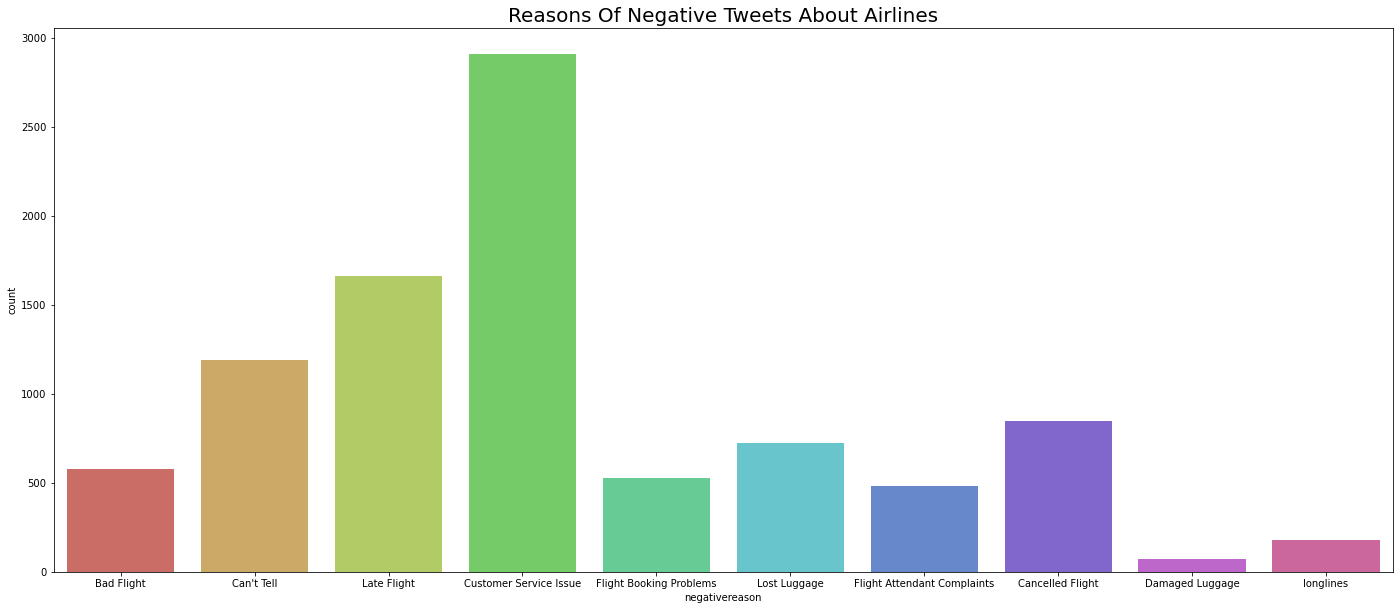

In [8]:
cprint('Reasons Of Negative Tweets :','green')
print(tweets.negativereason.value_counts())

plt.figure(figsize = (24, 10))
sns.countplot(x = 'negativereason', data = tweets, palette = 'hls')
plt.title('Reasons Of Negative Tweets About Airlines', fontsize = 20)
plt.show()

MLA

In [9]:
from sklearn.model_selection import train_test_split # Split Data 
from imblearn.over_sampling import SMOTE # Handling Imbalanced

# Model Building
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  

Splitting the sentiments


In [10]:
positive = tweets[tweets['airline_sentiment'] == 'positive'].text
neutral  = tweets[tweets['airline_sentiment'] == 'neutral'].text
negative  = tweets[tweets['airline_sentiment'] == 'negative'].text

Positive sentimets

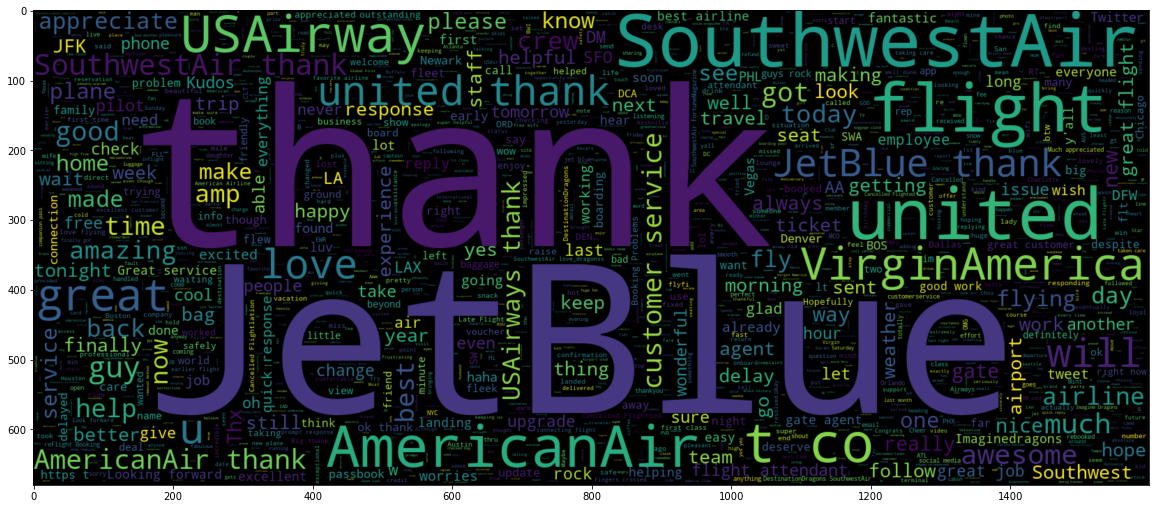

In [11]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(positive))
plt.imshow(worldcould_pos,interpolation = 'bilinear')

Negative sentiments

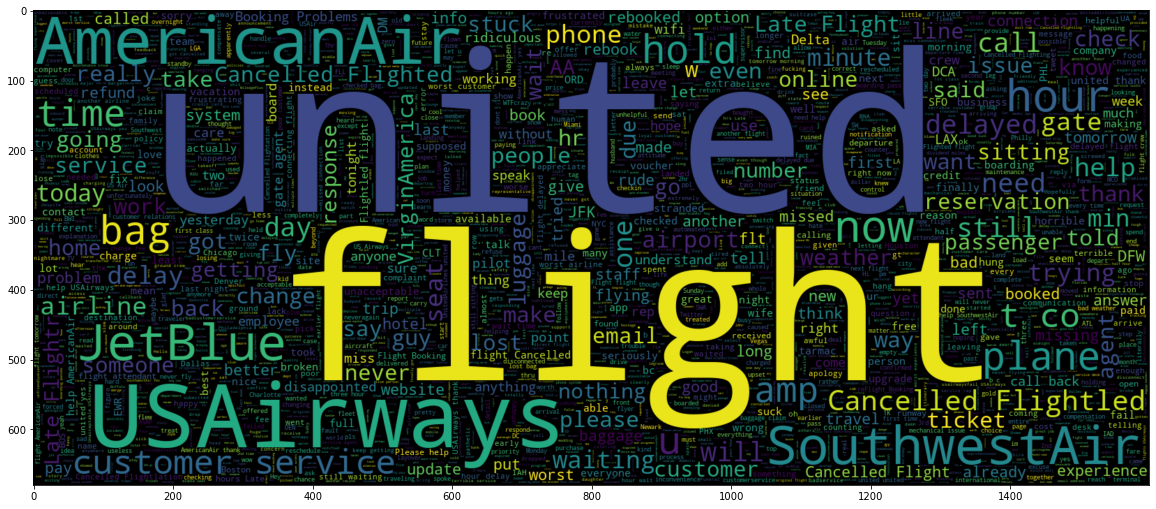

In [12]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(negative))
plt.imshow(worldcould_pos,interpolation = 'bilinear')
# ax.grid(False)

Neutral sentiments

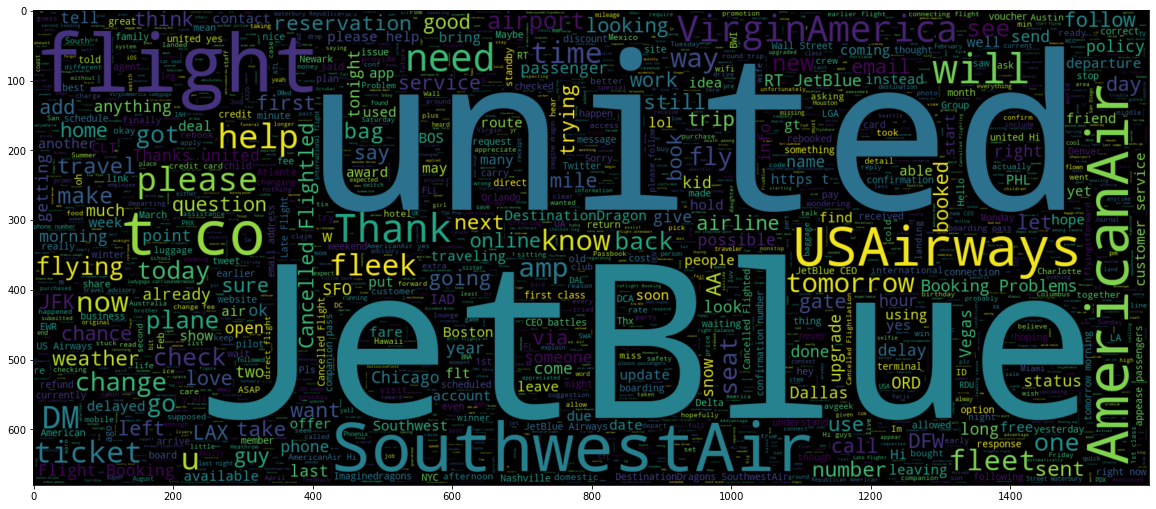

In [13]:
plt.figure(figsize = (20,20)) 
worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(neutral))
plt.imshow(worldcould_pos,interpolation = 'bilinear')
# ax.grid(False)

# Feature processing

In [14]:
#encode sentiments
def encode_sentiment(sentiment):
  if sentiment == "positive":
    return 2
  elif sentiment == "neutral":
    return 1
  elif sentiment == "negative":
    return 0


tweets.airline_sentiment = tweets.airline_sentiment.apply(lambda x : encode_sentiment(x))

# Data cleaning by: <a href = "https://www.kaggle.com/meisamraz/sentiment-analysis-96-acc-eda-text-preprocessing">Meisam Raz</a>

In [15]:
# Remove stop words
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html 
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Decontraction text
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text  

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute


In [16]:
tweets['final_text'] = tweets['negativereason'].fillna('') + ' ' + tweets['text'] 

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# clean utility
def clean_text(tweets):
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_username(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_url(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_emoji(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : decontraction(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : seperate_alphanumeric(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : unique_char(cont_rep_char,x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : char(x))
    tweets['final_text'] = tweets['final_text'].apply(lambda x : x.lower())
    tweets['final_text'] = tweets['final_text'].apply(lambda x : remove_stopwords(x))

    return tweets


# apply the functions
tweets = clean_text(tweets)


Cleaning input for the prediction

In [19]:
def clean_text_train(tweets):
    tweets = remove_emoji(tweets)
    tweets = decontraction(tweets)
    tweets = seperate_alphanumeric(tweets)
    tweets = unique_char(cont_rep_char,tweets)
    tweets = char(tweets)
    tweets = remove_stopwords(tweets)
    tweets = tweets.lower()
    tweets = remove_url(tweets)
    tweets = remove_username(tweets)

    return tweets

In [21]:
X = tweets['final_text']
y = tweets['airline_sentiment']

X.shape

(14640,)

TFidVectorizer
- Convert a collection of raw documents to a matrix of TF-IDF features.

In [22]:
# apply tfidf to the cleaned text
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Smote
- SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. 
- It is a technique that takes minority samples and creates synthetic samples from them.
- It is used to deal with the imbalanced data problem.
- it generates the virtual samples from the minority class by linear interpolation. for the minority class.

<a href = "https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/"> Link to the article </a>

In [23]:
#applying smote
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_tfidf,y)

In [24]:
#import adaboost
from sklearn.ensemble import AdaBoostClassifier
# import XGBoost
from xgboost import XGBClassifier

In [25]:
#Machine Learning Algorithms
MLA = [
    #Ensemble Methods
    RandomForestClassifier(), #Random Forest
    XGBClassifier(), #XGBoost
    GradientBoostingClassifier(), #GBM
    AdaBoostClassifier(), # adaboost
    SVC(), #support vector machines
    MultinomialNB(), #naive bayes
    LogisticRegression(), #logistic regression
    DecisionTreeClassifier(), #decision tree
]

Fit models and predict

In [26]:
# split the data into training and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.20, random_state=42)

In [27]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate

In [28]:
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

# Fitting the models

In [ ]:
#cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

MLA_predict = []

row_index = 0
for alg in MLA:
    # set the name of the algorithm
    alg_name = alg.__class__.__name__
    print("Training for {}".format(alg_name))

    MLA_compare.loc[row_index, 'MLA Name'] = alg_name
    # set the algorithm parameters
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    # score model with cross validation
    cv_results = cross_validate(alg, x_sm, y_sm, cv=cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3

    # fit the algorithm on the data
    alg.fit(X_train, y_train)
    # predict the response
    y_pred = alg.predict(X_test)
    MLA_predict.append(y_pred)

    row_index += 1
    
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

# Model performance

Classification Report of 'RandomForestClassifier'
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1895
           1       0.95      0.94      0.94      1786
           2       0.95      0.95      0.95      1826

    accuracy                           0.96      5507
   macro avg       0.96      0.96      0.96      5507
weighted avg       0.96      0.96      0.96      5507



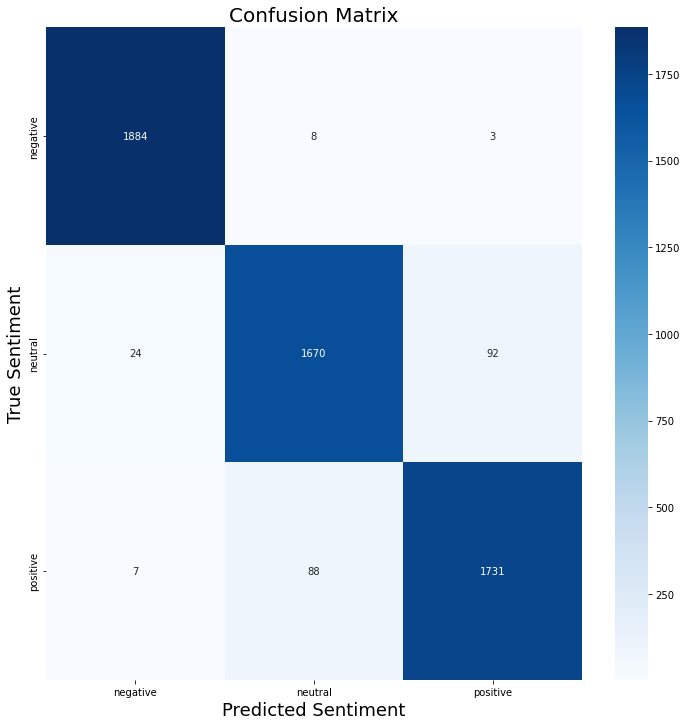

Classification Report of 'XGBClassifier'
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1895
           1       0.86      0.91      0.89      1786
           2       0.92      0.86      0.89      1826

    accuracy                           0.92      5507
   macro avg       0.92      0.92      0.92      5507
weighted avg       0.92      0.92      0.92      5507



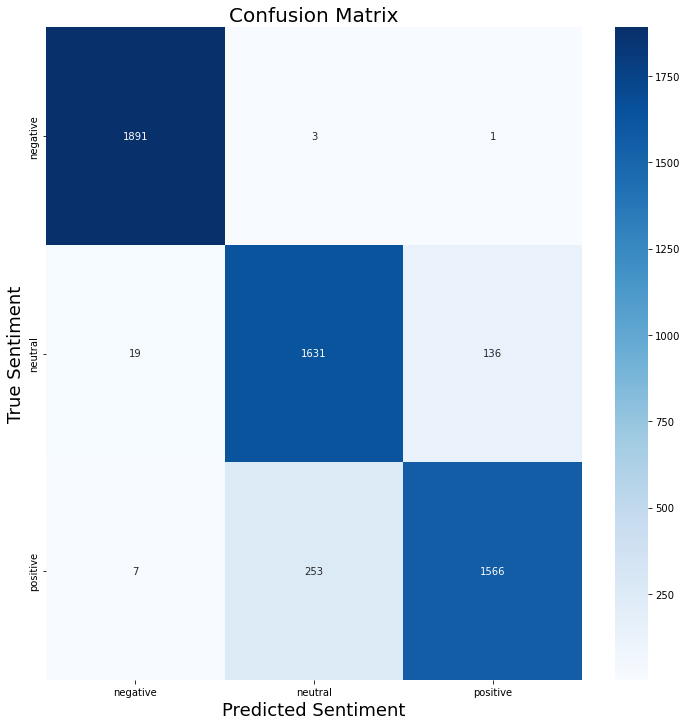

Classification Report of 'GradientBoostingClassifier'
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1895
           1       0.79      0.88      0.83      1786
           2       0.89      0.75      0.82      1826

    accuracy                           0.88      5507
   macro avg       0.88      0.88      0.88      5507
weighted avg       0.88      0.88      0.88      5507



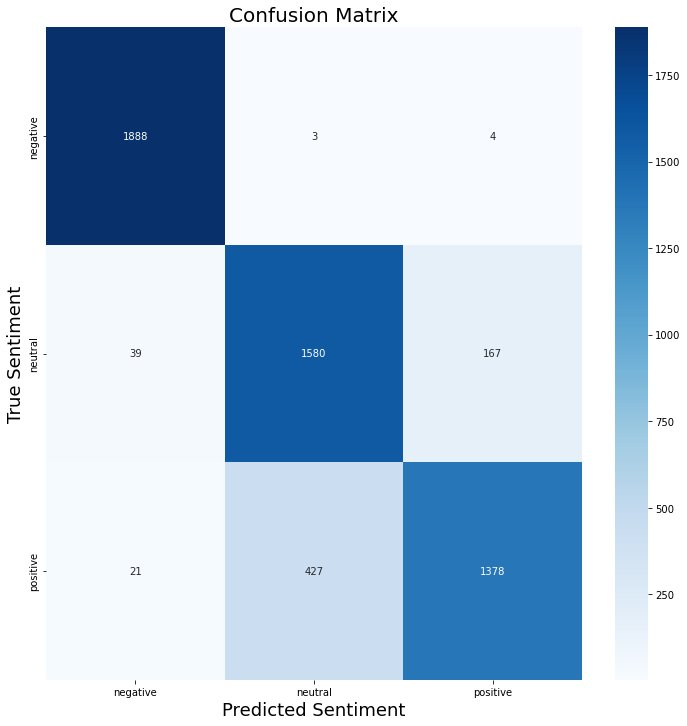

Classification Report of 'AdaBoostClassifier'
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1895
           1       0.71      0.85      0.78      1786
           2       0.83      0.66      0.74      1826

    accuracy                           0.83      5507
   macro avg       0.84      0.83      0.83      5507
weighted avg       0.84      0.83      0.83      5507



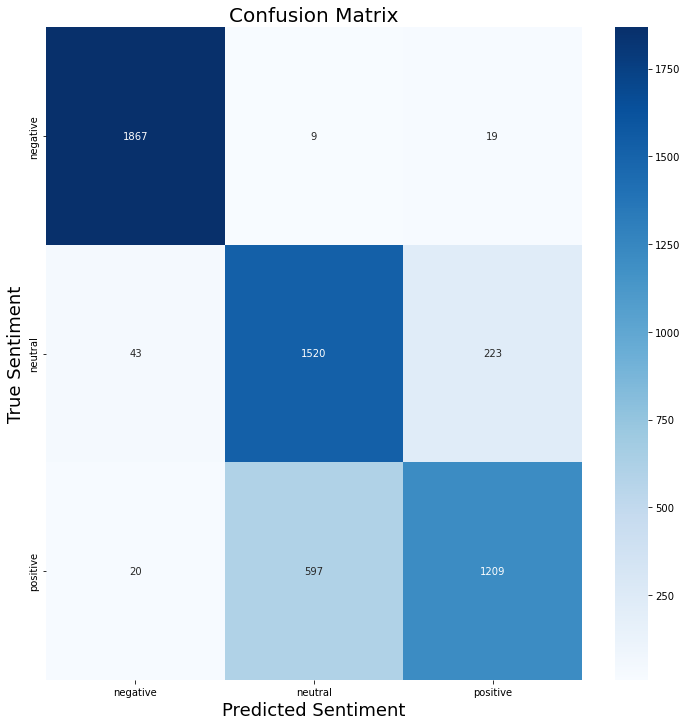

Classification Report of 'SVC'
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1895
           1       0.88      0.96      0.92      1786
           2       0.97      0.87      0.91      1826

    accuracy                           0.94      5507
   macro avg       0.94      0.94      0.94      5507
weighted avg       0.94      0.94      0.94      5507



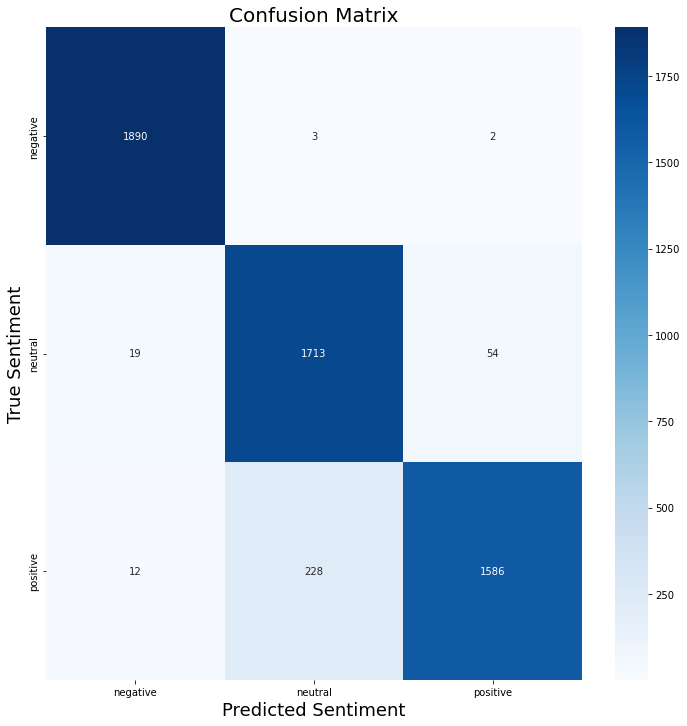

Classification Report of 'MultinomialNB'
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1895
           1       0.89      0.74      0.81      1786
           2       0.88      0.89      0.89      1826

    accuracy                           0.87      5507
   macro avg       0.87      0.86      0.86      5507
weighted avg       0.87      0.87      0.86      5507



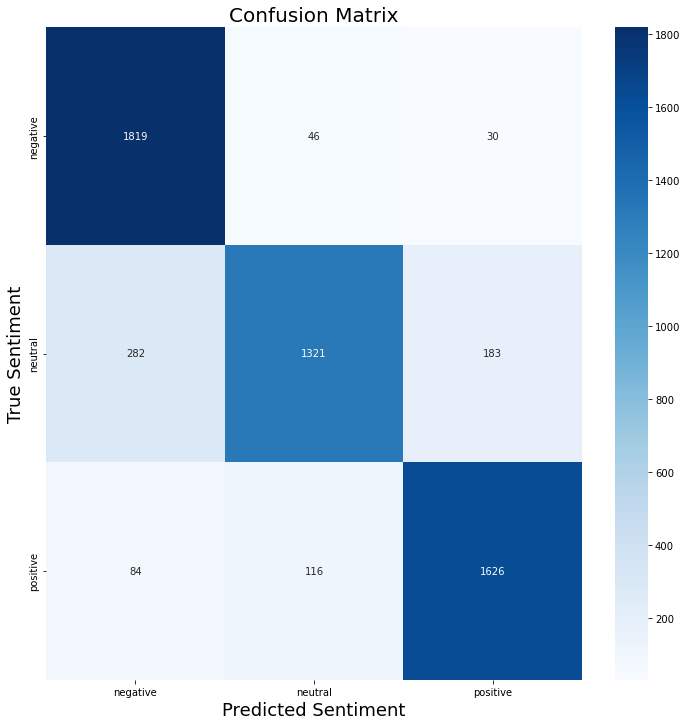

Classification Report of 'LogisticRegression'
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1895
           1       0.83      0.91      0.87      1786
           2       0.92      0.82      0.87      1826

    accuracy                           0.91      5507
   macro avg       0.91      0.91      0.91      5507
weighted avg       0.91      0.91      0.91      5507



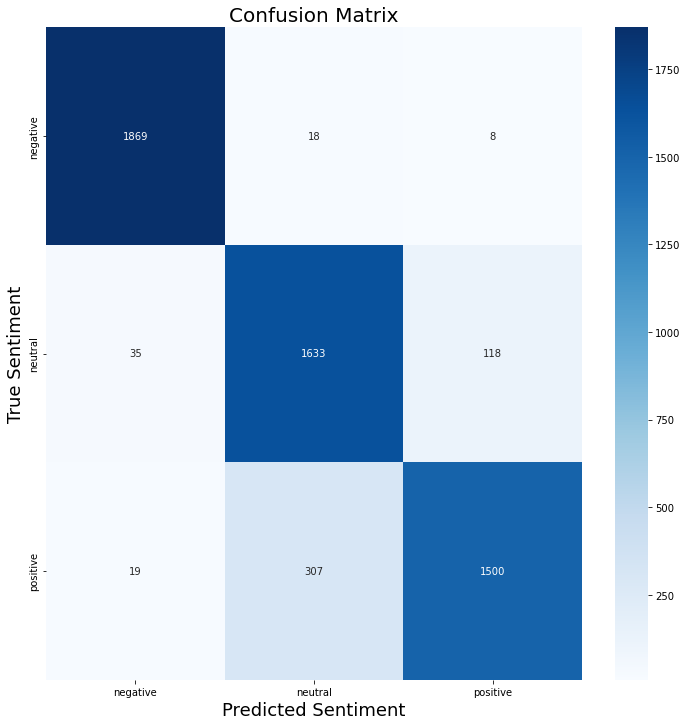

Classification Report of 'DecisionTreeClassifier'
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1895
           1       0.93      0.92      0.92      1786
           2       0.92      0.94      0.93      1826

    accuracy                           0.95      5507
   macro avg       0.95      0.95      0.95      5507
weighted avg       0.95      0.95      0.95      5507



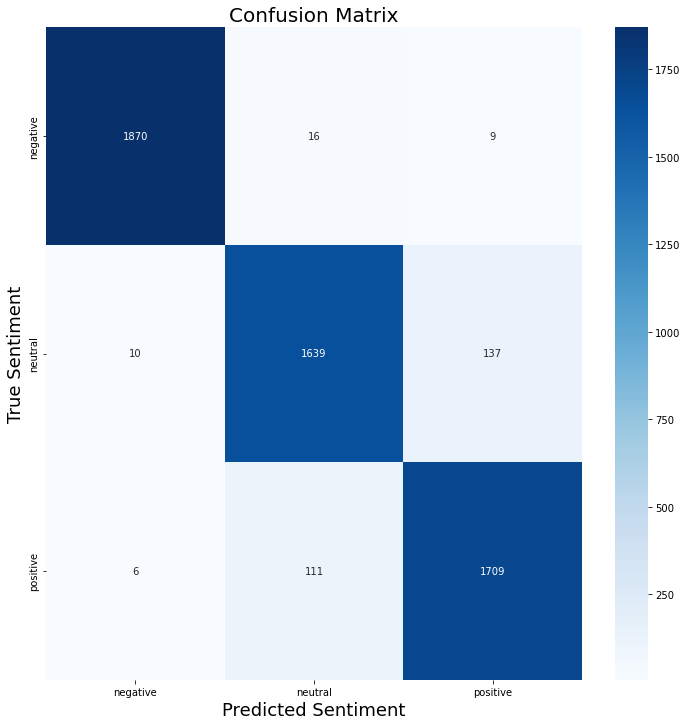

In [30]:
index = 0
for alg in MLA:
    # set the name of the algorithm
    alg_name = alg.__class__.__name__
    report = classification_report(y_test, MLA_predict[index])
    print(f"Classification Report of '{alg_name}'")
    print(report)
    

    matrix = confusion_matrix(y_test, MLA_predict[index])

    index += 1
    #confusion matrix
    plt.figure(figsize=(12, 12))
    sentiments = ['negative', 'neutral', 'positive']
    sns.heatmap(matrix, cmap=plt.cm.Blues, xticklabels=sentiments, yticklabels=sentiments, annot=True, fmt="d")
    plt.title("Confusion Matrix", fontsize=20)
    plt.ylabel('True Sentiment', fontsize=18)
    plt.xlabel('Predicted Sentiment', fontsize=18)
    plt.show()

Text(0.5, 0, 'Accuracy Score (%)')

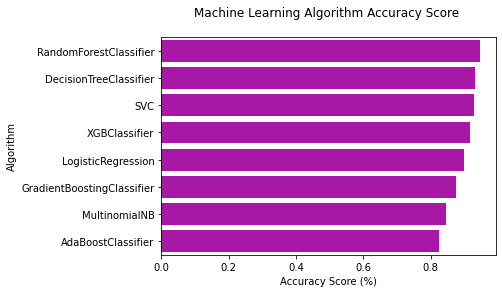

In [31]:
# sns barplot
sns.barplot(y=MLA_compare['MLA Name'], x=MLA_compare['MLA Test Accuracy Mean'], data=MLA_compare,color='m')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.ylabel('Algorithm')
plt.xlabel('Accuracy Score (%)')

ROC curves

In [25]:
#import roc
from sklearn.metrics import roc_curve, auc,roc_auc_score

Model to predict the sentiment

In [34]:
#import count vectorizer    
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# import tfidf
from sklearn.feature_extraction.text import TfidfTransformer

clf_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

clf_3.fit(X, y)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [44]:
def predict(tweet):
    tweet = clean_text_train(tweet)
    prediction = clf_3.predict([tweet])

    if prediction == 0:
        return 'negative'
    elif prediction == 1:
        return 'neutral'
    else:
        return 'positive'

Predict any tweet

In [45]:
prediction = predict('This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven''t even gone on my 1st trip yet!')
print(prediction)

positive
